# **Creating Helper Functions**

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# ** Selecting Albums to Purchase**

In [3]:
query = '''
        WITH usa_tracks_sold AS
           (
            SELECT il.* FROM invoice_line il
            INNER JOIN invoice i on il.invoice_id = i.invoice_id
            INNER JOIN customer c on i.customer_id = c.customer_id
            WHERE c.country = "USA"
           )
        SELECT 
            g.name genre_name,
            SUM(inl.quantity) total_quantity,
            CAST(SUM(inl.quantity) AS float)/CAST((SELECT SUM(quantity) FROM usa_tracks_sold) AS float) quantity_per
        FROM track t
        INNER JOIN usa_tracks_sold inl ON t.track_id = inl.track_id
        INNER JOIN genre g ON g.genre_id = t.genre_id
        GROUP BY 1
        ORDER BY total_quantity DESC 
        LIMIT 10
        '''
run_query(query)

,genre_name,total_quantity,quantity_per
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


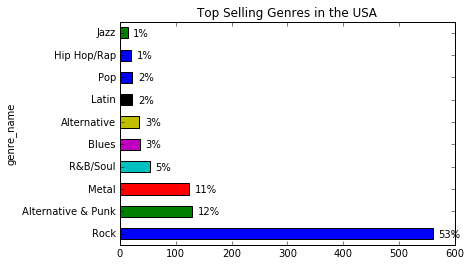

In [4]:
genre_sales_usa = run_query(query)
genre_sales_usa.set_index("genre_name", inplace=True, drop=True)
genre_sales_usa["total_quantity"].plot.barh(title="Top Selling Genres in the USA")

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "total_quantity"]
    label = (genre_sales_usa.loc[label, "quantity_per"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the top selling genres in the USA, we should purchase:
1. Red Tone's Punk music
2. Slim Jim Bites's Blues music
3. Meteor and the Girls's Pop music

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales. 

# **Analyzing Employee Sales Performance**

In [5]:
query1 = '''
        SELECT 
            e.first_name || " " || e.last_name employee_name,
            SUM(inv.total) sale_total,
            e.hire_date
        FROM employee e
        INNER JOIN customer c ON e.employee_id = c.support_rep_id
        INNER JOIN invoice inv ON c.customer_id = inv.customer_id
        GROUP BY 1
        '''
run_query(query1)

,employee_name,sale_total,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


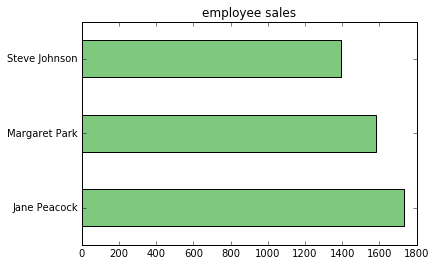

In [6]:
employee_sale = run_query(query1)
employee_sale.set_index("employee_name", inplace=True, drop=True)
employee_sale["sale_total"].plot.barh(title="employee sales", xlim=(0,1800), colormap=plt.cm.Accent)
plt.ylabel('')


The difference in sales roughly corresponds with the differences in their hiring dates

# **Analyzing Sales by Country**

In [7]:
q =  '''
WITH country_sort AS
    (
    SELECT 
        CASE
            WHEN (
                SELECT
                COUNT(*)
                FROM customer
                WHERE country = c.country 
            ) = 1 THEN "other"
        ELSE c.country
        END AS country,
        COUNT(DISTINCT c.customer_id) customer_number,
        SUM(inv.total) total_sales,
        SUM(inv.total)/COUNT(DISTINCT c.customer_id) ave_value_per_customer,
        SUM(inv.total)/COUNT(DISTINCT inv.invoice_id) ave_order_value
    FROM customer c
    INNER JOIN invoice inv ON c.customer_id = inv.customer_id
    GROUP BY 1
    )
    
SELECT
    country,
    customer_number,
    total_sales,
    ave_value_per_customer,
    ave_order_value
FROM 
    (
    SELECT 
        cs.*,
        CASE
            WHEN cs.country = 'other' THEN 1
            ELSE 0
        END AS sort
    FROM country_sort cs
    ORDER BY total_sales DESC
    )
    ORDER BY sort ASC
'''
run_query(q)

,country,customer_number,total_sales,ave_value_per_customer,ave_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,other,15,1094.94,72.996000,7.448571


# **Visualizing Sales by Country**

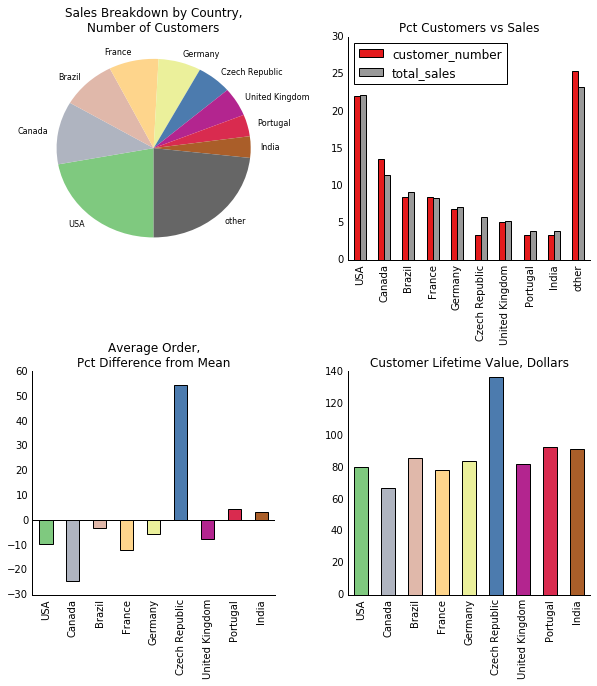

In [8]:
import numpy as np
sale_country = run_query(q)
sale_country.set_index("country", inplace=True, drop=True)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
fig.subplots_adjust(hspace=.5, wspace=.3)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sale_country.shape[0])]

# top left
sales_breakdown = sale_country["total_sales"].copy()
sales_breakdown.name = ''
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customer_number","total_sales"]
custs_vs_dollars = sale_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
cd_pct = sale_country["ave_value_per_customer"].copy()
cd_pct.index.name = ''
cd_pct.drop("other", inplace=True)
cd_pct = cd_pct * 100 / cd_pct.mean() - 100
cd_pct.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.axhline(0, color='k')
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# bottom right
ltv = sale_country["ave_value_per_customer"].copy()
ltv.index.name = ''
ltv.drop("other", inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

Based on the data, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# **Albums vs Individual Tracks**

In [18]:
q = '''
WITH track_album AS(
    SELECT 
        invoice_id,
        MIN(track_id) first_track_id
    FROM invoice_line 
    GROUP BY 1
)
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
(
    SELECT
        ta.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ta.first_track_id
                                    )
                
                EXCEPT
                
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ta.invoice_id
                ) IS NULL
            
            AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ta.invoice_id
                
                EXCEPT
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id
                                    FROM track t2
                                    WHERE t2.track_id = ta.first_track_id
                                    )
                ) IS NULL
            THEN "Yes"
            ELSE "No"
        END AS album_purchase
    FROM track_album ta
)
GROUP BY album_purchase
'''
run_query(q)

,album_purchase,number_of_invoices,percent
0,No,500,0.814332
1,Yes,114,0.185668


,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
